In [5]:
import json
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def load_data(path):
    with open(path) as f:
        data = json.load(f)
    return data

In [7]:
def get_chapter_dict():
# 读取 CSV 文件，指定编码为 UTF-8
    chapter_df = pd.read_csv('D:\\github_repo_forked\\lifetime_value\\kuaidian\\clean\\关卡字典_1.csv', encoding='utf-8')

    # 以 chapter_name 列为索引并转换为字典
    chapter_dict = chapter_df.set_index('chapter_name')
    ret = {}
    count = 0
    for name in chapter_dict.index:
        ret[name] = count
        count += 1
    return ret

def get_chapter_index_dict():
    chapter_df = pd.read_csv('D:\\github_repo_forked\\lifetime_value\\kuaidian\\clean\\关卡字典_1.csv', encoding='utf-8')
    chapter_dict = chapter_df.to_dict()
    return chapter_dict

In [47]:
get_chapter_index_dict()


{'chapter_name': {0: 'mowanchongsheng',
  1: 'fanchenggaofeng',
  2: 'homeTeach',
  3: 'kongbuchuzu',
  4: 'zhunongdaxuesheng2',
  5: 'facePainting',
  6: 'seafish8',
  7: 'baochipinheng',
  8: 'findFaker2',
  9: 'meeting',
  10: 'zhuangshengnonggui3',
  11: 'ghostSpeak',
  12: 'ghostSoup',
  13: 'huilaojiazhuangban',
  14: 'hellTravel',
  15: 'yinianzhijian',
  16: 'familyJoker',
  17: 'wodepengyou',
  18: 'chuxizhuoyao',
  19: 'runAway',
  20: 'sangnajiare',
  21: 'guiyichuangdian',
  22: 'yugangqiusheng',
  23: 'fangliangtaosheng',
  24: 'shitoujiandaobu',
  25: 'weixianlouti',
  26: 'monsterCommunity',
  27: 'zhuangshengnonggui2',
  28: 'strangeFish',
  29: 'huoguojiala',
  30: 'fakePotato',
  31: 'bianbienvhanzi',
  32: 'bodyBox',
  33: 'tianmingzhennv',
  34: 'sebo',
  35: 'taoliweixian',
  36: 'strangeDinner',
  37: 'nightHouse',
  38: 'angle',
  39: 'mayOut',
  40: 'bianbiepinkunhu',
  41: 'yInMirror',
  42: 'shiyijianjinghun',
  43: 'redStone',
  44: 'xuxiandekaoyan',
  45: 'b

In [21]:

def clean_origin_data(data):


    feature = {}
    feature['event'] = []
    if data['code'] != 200:
        return feature
    event_list = data['data'].get('flow', [])
    # 处理初始信息
    first_event = event_list[0] if event_list else {}
    params = first_event.get('params', {})
    feature['os_version'] = params.get('os_version', np.nan)
    feature['device_brand'] = params.get('device_brand', np.nan)
    feature['loc_city_id'] = params.get('loc_city_id', np.nan)
    feature['user_id'] = first_event.get('user_id', np.nan)

    for event in event_list:
        ev = {}
        ev['event_name'] = event.get('event_name', np.nan)
        ev['server_time'] = event.get('server_time', np.nan)

        event_params = event.get('params', {})
        ev['stay_duration'] = event_params.get('stay_duration', np.nan)
        ev['chapter_name'] = event_params.get('chapter_name', np.nan)
        ev['chapter'] = event_params.get('chapter', np.nan)
        ev['sub_chapter'] = event_params.get('sub_chapter', np.nan)
        ev['cost_time'] = event_params.get('cost_time', np.nan)
        ev['stay_duration'] = event_params.get('stay_duration', np.nan)
        feature['event'].append(ev)

    return feature


In [9]:
def get_rank_data(feature_data):
    if feature_data['event'] == []:
        return None
    # 1. 反转事件列表
    events = feature_data['event'][::-1]
    
    # 2. 按章节组织数据
    chapter_dict = {}
    for event in events:
        chapter_name = event.get('chapter_name')
        if pd.isna(chapter_name):
            continue
            
        if chapter_name not in chapter_dict:
            chapter_dict[chapter_name] = {
                'events': [],
                'score': None,
              'server_time': None
            }
        
        chapter_dict[chapter_name]['events'].append({
            'event_name': event.get('event_name'),
            'cost_time': event.get('cost_time'),
            'server_time': event.get('server_time')
        })
    
    # 3. 为每个章节打分
    for chapter, data in chapter_dict.items():
        events = data['events']
        has_retry =  any(e['event_name'] == '重新开始' for e in events)
        has_ad = any(e['event_name'] == '观看广告' for e in events)
        success = any(e['event_name'] == '关卡通关' for e in events)
        
        if success and has_ad:
            score = 5
        elif success and not has_ad:
            score = 4
        elif not success and has_ad:
            score = 3
        elif not success and not has_ad:
            if has_retry:
                score = 2
            else:
                score = 1
        else:
            score = 0
            
        data['score'] = score
        data['last_time'] = events[-1]['server_time']
    
    # 4. 保存结果
    result = {
        'user_id': feature_data['user_id'],
        'chapter_scores': chapter_dict
    }
    
    return result



In [22]:
data = load_data(r'D:\github_repo_forked\lifetime_value\kuaidian\quickgames_user_behavior\hidfile_ks_120592009db2fd5fe907fb38a3e032d2ef.json')
feature_data = clean_origin_data(data)
rank_data = get_rank_data(feature_data)
print(rank_data)

{'user_id': 'hidfile_ks_120592009db2fd5fe907fb38a3e032d2ef', 'chapter_scores': {'jinjishoushu': {'events': [{'event_name': '打开广告', 'cost_time': nan, 'server_time': 1739842359}, {'event_name': '观看广告', 'cost_time': nan, 'server_time': 1739842386}, {'event_name': '关卡开始加载', 'cost_time': nan, 'server_time': 1739842386}, {'event_name': '关卡开始', 'cost_time': nan, 'server_time': 1739842390}, {'event_name': '打开广告', 'cost_time': nan, 'server_time': 1739842428}, {'event_name': '观看广告', 'cost_time': nan, 'server_time': 1739842451}, {'event_name': '打开广告', 'cost_time': nan, 'server_time': 1739842470}, {'event_name': '观看广告', 'cost_time': nan, 'server_time': 1739842493}, {'event_name': '关卡通关', 'cost_time': '197.454', 'server_time': 1739842583}], 'score': 5, 'server_time': None, 'last_time': 1739842583}, 'bengtazhishi': {'events': [{'event_name': '关卡开始加载', 'cost_time': nan, 'server_time': 1739842586}, {'event_name': '关卡开始', 'cost_time': nan, 'server_time': 1739842587}, {'event_name': '打开广告', 'cost_time':

In [11]:
import math

def extract_chapter_sequence(feature_data):
    chapter_sequence = []
    event_sequence = feature_data['event']
    if event_sequence == []:
        return []
    
    for event in event_sequence:
        chapter_name = event.get('chapter_name')
        if not (isinstance(chapter_name, float) and math.isnan(chapter_name)):
            chapter_sequence.append(chapter_name)
    
    # 删除序列中的 nan
    chapter_sequence = [x for x in chapter_sequence if not (isinstance(x, float) and math.isnan(x))]
        # 处理连续重复的元素
    if chapter_sequence:
        new_sequence = [chapter_sequence[0]]
        for item in chapter_sequence[1:]:
            if item != new_sequence[-1]:
                new_sequence.append(item)
        chapter_sequence = new_sequence
    chapter_dict = get_chapter_dict()
    number_sequence = [chapter_dict[x] for x in chapter_sequence if x in chapter_dict]
    filtered_sequence = [num for i, num in enumerate(number_sequence) if i == 0 or num != number_sequence[i-1]]

    return filtered_sequence


In [12]:
def filter_chapter_sequence(rank_data, chapter_sequence):
    if chapter_sequence == []:
        return []
    index_dict = get_chapter_index_dict()['chapter_name']
    new_chapter_sequence = []
    for chapter_index in chapter_sequence:
        chapter_name = index_dict[chapter_index]
        if rank_data['chapter_scores'][chapter_name]['score']  >= 3 :
            new_chapter_sequence.append(chapter_index)
    return new_chapter_sequence

In [13]:
user216behavior = r'C:\Users\jingyuan.hao\Downloads\user216behavior'
filelist = os.listdir(user216behavior)

all_data = []  # 用于存储所有处理后的数据

In [23]:
quickgames_user_behavior = r'D:\github_repo_forked\lifetime_value\kuaidian\quickgames_user_behavior'
all_data = []  # 用于存储所有处理后的数据
all_rank_data = []
rank_path = os.path.join(r'D:\github_repo_forked\lifetime_value\kuaidian\clean', f'rank_data_all.json')

break_file = ''
if break_file in filelist:
    break_index = filelist.index(break_file)
    filelist = filelist[break_index+1:]
total = len(filelist)
for index,file in enumerate(filelist):
    progress_percent = (index/total)*100
    print(f'-----  {file} {index}/{total} ({progress_percent:.2f}%)  -----')    
    data = load_data(os.path.join(user216behavior, file))
    feature_data = clean_origin_data(data)
    chapter_sequence = extract_chapter_sequence(feature_data)
    rank_data = get_rank_data(feature_data)
    if rank_data is not None:
        all_rank_data.append(rank_data)

    new_sequence = filter_chapter_sequence(rank_data, chapter_sequence)
    feature_data['chapter_sequence'] = new_sequence
 
    del feature_data['event']
        # Convert dictionary to DataFrame
    if isinstance(feature_data, dict):
        feature_data = pd.DataFrame([feature_data])
    all_data.append(feature_data)
with open(rank_path, 'w', encoding='utf-8') as f:
    json.dump(all_rank_data, f, ensure_ascii=False, indent=4)
    f.write('\n') 
combined_data = pd.concat(all_data, ignore_index=True)
csv_path = os.path.join(r'D:\github_repo_forked\lifetime_value\kuaidian\clean', 'combined_data_filter_all.csv')
combined_data.to_csv(csv_path, index=False)

-----  hidfile_bl_03ed4b21658f9dc17ba70a17630876f4.json 0/34986 (0.00%)  -----
-----  hidfile_bl_05d193809c4f177ee63331d675f3c24e.json 1/34986 (0.00%)  -----
-----  hidfile_bl_08aa1ec567186353a0e0cc4a0d24c01c.json 2/34986 (0.01%)  -----
-----  hidfile_bl_0e22fbd68040050d8f9f4f43336169b8.json 3/34986 (0.01%)  -----
-----  hidfile_bl_1042d952226e22e59457497f9d2441c3.json 4/34986 (0.01%)  -----
-----  hidfile_bl_10fb191350d8a9fe4c8f971c0fc1cace.json 5/34986 (0.01%)  -----
-----  hidfile_bl_1123056e6f55d76baab93259c6493838.json 6/34986 (0.02%)  -----
-----  hidfile_bl_1800e00c4fa1a3bba3d9c20abcce923b.json 7/34986 (0.02%)  -----
-----  hidfile_bl_18fb5efdecc05fa504d6b1d86d5b9fd3.json 8/34986 (0.02%)  -----
-----  hidfile_bl_1ad90bd706494e40e89b70a39eed1026.json 9/34986 (0.03%)  -----
-----  hidfile_bl_1b4af472ba3f31191f8cce9cb026116f.json 10/34986 (0.03%)  -----
-----  hidfile_bl_1c14169af4853b395ccacca7f12ff29e.json 11/34986 (0.03%)  -----
-----  hidfile_bl_1c995034578fa967d8785f5b067174b9

### 准备协同过滤算法需要的数据
1. 整理格式   user_id, item_id, score, timestamp
2. 检查缺少的值
3. 处理缺少值

In [33]:
def extract_user_item_data(rank_data, output_path):
    """
    从rank_data中提取结构化数据并写入CSV
    格式：userid,chapter,score,time
    """
    import csv
    
    # 准备数据容器
    csv_rows = []
    chapter_mapping = get_chapter_dict()

    # 遍历每个用户的rank数据
    for user_data in rank_data:
        if user_data is None:
            continue
            
        user_id = user_data['user_id']
        chapters = user_data['chapter_scores']
        
        # 提取每个章节的数据
        for chapter_name, chapter_data in chapters.items():
            # 转换为数字并过滤不存在映射的章节
            chapter_num = chapter_mapping.get(chapter_name)
            if chapter_num is None:  # 新增过滤条件
                continue
                
            csv_rows.append({
                'userid': user_id,
                'chapter': chapter_num,  # 改为存储数字编号
                'score': chapter_data['score'],
                'time': chapter_data['last_time']
            })


    # 写入CSV文件
    with open(output_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['userid', 'chapter', 'score', 'time'])
        writer.writeheader()
        writer.writerows(csv_rows)

# 使用示例
# rank_data = [get_rank_data(feature) for feature in raw_features]
# extract_rank_to_csv(rank_data, "chapter_scores.csv")



In [34]:
rank_path = os.path.join(r'D:\github_repo_forked\lifetime_value\kuaidian\clean', f'rank_data_all.json')

with open(rank_path, 'r') as file:
    rank_data = json.load(file)
extract_user_item_data(rank_data, 'D:\\github_repo_forked\\lifetime_value\\kuaidian\\clean\\user_item.csv')

In [35]:
def analyze_missing_data(csv_path):
    """分析CSV文件中缺失值的分布情况"""
    import pandas as pd
    from collections import defaultdict
    
    # 读取CSV数据
    df = pd.read_csv(csv_path)
    
    # 统计总缺失值
    missing_stats = {
        'total_missing': df.isnull().sum().sum(),
        'columns_missing': dict(df.isnull().sum()),
        'column_percent': dict(df.isnull().mean() * 100)
    }
    
    # 按章节分析缺失分布
    chapter_missing = defaultdict(int)
    if 'chapter' in df.columns:
        for _, row in df[df.isnull().any(axis=1)].iterrows():
            chapter_missing[row['chapter']] += 1
    
    # 打印统计报告
    print(f"总缺失值数量: {missing_stats['total_missing']}")
    print("\n各字段缺失统计:")
    for col, count in missing_stats['columns_missing'].items():
        print(f"- {col}: {count} 处 ({missing_stats['column_percent'][col]:.2f}%)")
    
    print("\n按章节缺失分布:")
    for chap, cnt in sorted(chapter_missing.items(), key=lambda x: -x[1]):
        print(f"- {chap}: {cnt} 处缺失")

# 使用示例
analyze_missing_data("D:\\github_repo_forked\\lifetime_value\\kuaidian\\clean\\user_item.csv")


总缺失值数量: 0

各字段缺失统计:
- userid: 0 处 (0.00%)
- chapter: 0 处 (0.00%)
- score: 0 处 (0.00%)
- time: 0 处 (0.00%)

按章节缺失分布:


In [36]:
# 删除缺少的chapter的行
user_item_df = pd.read_csv('D:\\github_repo_forked\\lifetime_value\\kuaidian\\clean\\user_item.csv')


In [37]:
user_item_df = user_item_df[user_item_df['chapter'].notnull()]
print(user_item_df.dtypes)


unique_chapters = user_item_df['chapter'].unique()
print(unique_chapters)


score_distribution = user_item_df['chapter'].value_counts()
print(score_distribution)

userid     object
chapter     int64
score       int64
time        int64
dtype: object
[ 45  42  43  44  41  40  39  49 314  48  47  46 304 280 386 275 278 444
 495 254 328 252  62 337 339 341 343  59 505  89 312  96  97 212 137  99
 100  60  58 182 218 199 181 198 526 516 482 381 175  52  53 230 231 232
 235 236 240  72  73 269 350 443 130 134 131 136 139 141 145 143 146 147
 144 148 150 101 115  51  54  78 449  68  61  55  84  64  63  50 174  65
  66  67  69  70  71  74  75  77  81 246 243 228 227 241 333 373 364 374
 369 368 367 370 249 342 281 306 310 338 321 327 324 331 345  98 102 108
 129 132 183 113 153 163 151 142 152 157 158 450 390 391 394 392 366 361
 355 371 178 172  57 105 215 164 245 123 225  56 224 112 120 124 119 117
 547 253 308 299 468 276 127 229 244 261 265 160 169 179 166 171 170 118
 121 122 125  82 109 128 209 222 211 216 268 251 309 250  91 340 313 458
 459 551 535 537 473 480 489 103 302 200 522 475 116  15  26   9  13  18
  25 431  32  34  33  36 259 447 382 4

In [40]:
import time
max_time = user_item_df['time'].max()
print("The maximum time is:", max_time)
min_time = user_item_df['time'].min()
print("The minimum time is:", min_time)
# 转成日期时分秒
max_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(max_time))
min_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(min_time))
print("The minimum time is:", min_time)
print("The maximum time is:", max_time)

The maximum time is: 1739721591
The minimum time is: 1738491690
The minimum time is: 2025-02-02 18:21:30
The maximum time is: 2025-02-16 23:59:51


### 准备多分类算法的数据


In [15]:
import ast
filter_all_df = pd.read_csv('D:\\github_repo_forked\\lifetime_value\\kuaidian\\clean\\combined_data_filter_all.csv', encoding='utf-8')
filter_all_df.head()
filter_all_df['chapter_sequence'] = filter_all_df['chapter_sequence'].apply(ast.literal_eval)





0                         []
1       [49, 42, 44, 67, 65]
2                         []
3                         []
4                 [131, 168]
                ...         
7490                      []
7491                      []
7492                      []
7493                      []
7494                      []
Name: chapter_sequence, Length: 7495, dtype: object

统计序列长度分布

In [47]:
def analyze_sequence_lengths(sequences):
    # Calculate lengths
    lengths = sequences.apply(len)
    filtered_lengths = lengths[lengths >= 3]
    print('total seq counts: ',sum(filtered_lengths))
    # Count occurrences
    length_counts = filtered_lengths.value_counts().sort_index()
    
    # Display statistics
    print("Sequence Length Distribution:")
    print(length_counts)
    
    # Optional: Plot distribution
    plt.figure(figsize=(10, 6))
    length_counts.plot(kind='bar')
    plt.title('Chapter Sequence Length Distribution')
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.show()
    

    return length_counts

total seq counts:  10888
Sequence Length Distribution:
chapter_sequence
3     434
4     282
5     193
6     159
7     129
8     108
9      65
10     52
11     31
12     32
13     37
14     10
15     21
16     17
17     13
18     12
19      8
20      8
21      7
22      6
23      5
24      4
25      2
26      3
27      2
28      1
29      3
30      1
32      1
33      2
35      2
Name: count, dtype: int64


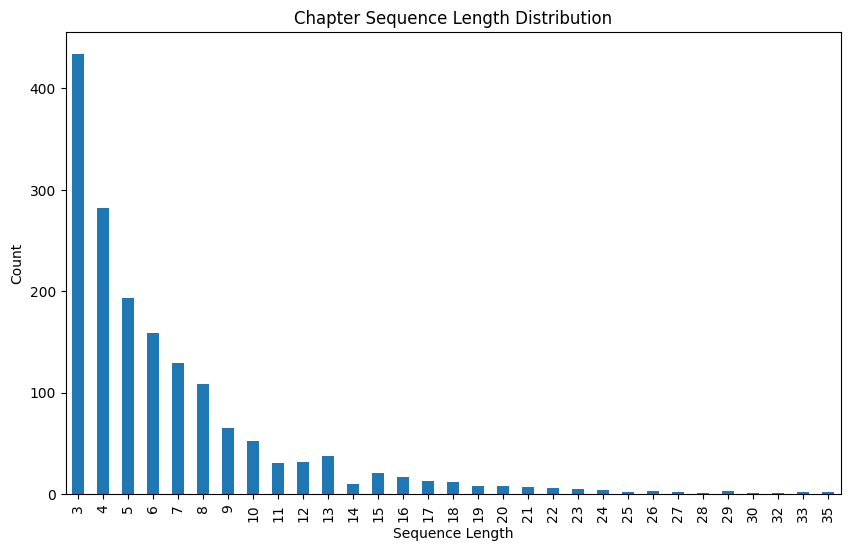

chapter_sequence
3     434
4     282
5     193
6     159
7     129
8     108
9      65
10     52
11     31
12     32
13     37
14     10
15     21
16     17
17     13
18     12
19      8
20      8
21      7
22      6
23      5
24      4
25      2
26      3
27      2
28      1
29      3
30      1
32      1
33      2
35      2
Name: count, dtype: int64

In [48]:
analyze_sequence_lengths(filter_all_df['chapter_sequence'])


统计关卡被玩的总数目，top的游戏

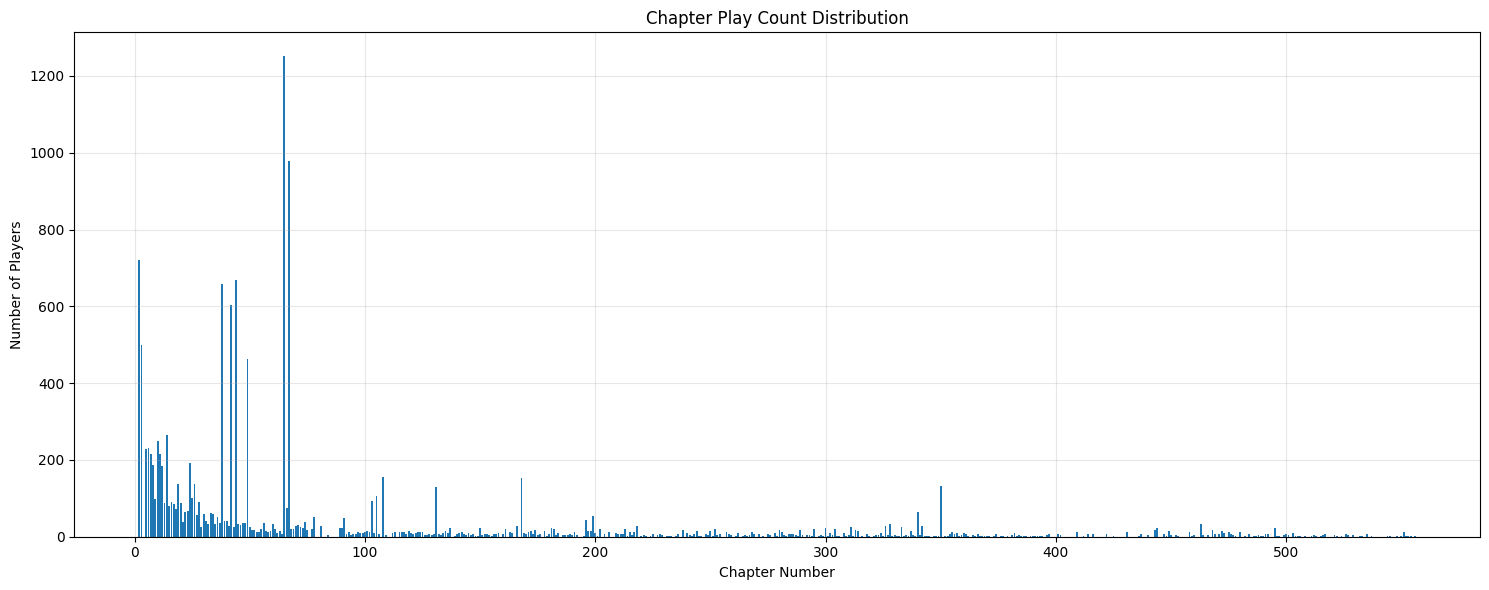

Total chapters played: 419
Most played chapter: 65
Max players: 1251
[ 721  500  228  231  215  186   99  249  215  185   89  266   79   91
   86   72  136   88   38   64   66  191  100  138   56   90   26   60
   42   33   63   60   34   52   35  658   41   40   29  604   25  668
   33   30   37   35  462   26   17   18   13   11   20   36   14   12
   14   33   19    9   16    8 1251   74  979   19   20   28   30   25
   22   39   17   19   52   27    4   22   22   50    6   11    4    8
    6   12    9   10   12   16   12   94    9  105    6  155    4   10
   11   11   13   12    7   14    9    7    9   11   11   13    5    4
    8    5    7  130    8    4   10   15   10   22    3    8    9   12
    7    5    9    5    6    3    3   22    5    6    6    4    2    6
    8   10    8   20   12   10   28  152   10    6   11   14    6   17
    5    6   16    1    7   23   21    5    9    4    4    5    6    4
   12    5    2   44   15   15   55   10    1   20    8   12   10    6
    7   

In [34]:
import ast
def analyze_chapter_counts(sequences):
    # Initialize count array
    count = [0] * 1000
    # Process sequences
    for seq in sequences:
        for chapter_num in seq:
            count[int(chapter_num)] += 1
    
    # Convert to numpy array for easier plotting
    import numpy as np
    count_array = np.array(count)
    
    # Filter out zeros for better visualization
    non_zero_indices = np.nonzero(count_array)[0]
    non_zero_counts = count_array[non_zero_indices]
    
    # Plot distribution
    plt.figure(figsize=(15, 6))
    plt.bar(non_zero_indices, non_zero_counts)
    plt.title('Chapter Play Count Distribution')
    plt.xlabel('Chapter Number')
    plt.ylabel('Number of Players')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total chapters played: {len(non_zero_indices)}")
    print(f"Most played chapter: {non_zero_indices[np.argmax(non_zero_counts)]}")
    print(f"Max players: {np.max(non_zero_counts)}")
    print(non_zero_counts)
    return count_array

# Usage
# filter_all_df['chapter_sequence'] = filter_all_df['chapter_sequence'].apply(ast.literal_eval)
chapter_counts = analyze_chapter_counts(filter_all_df['chapter_sequence'])

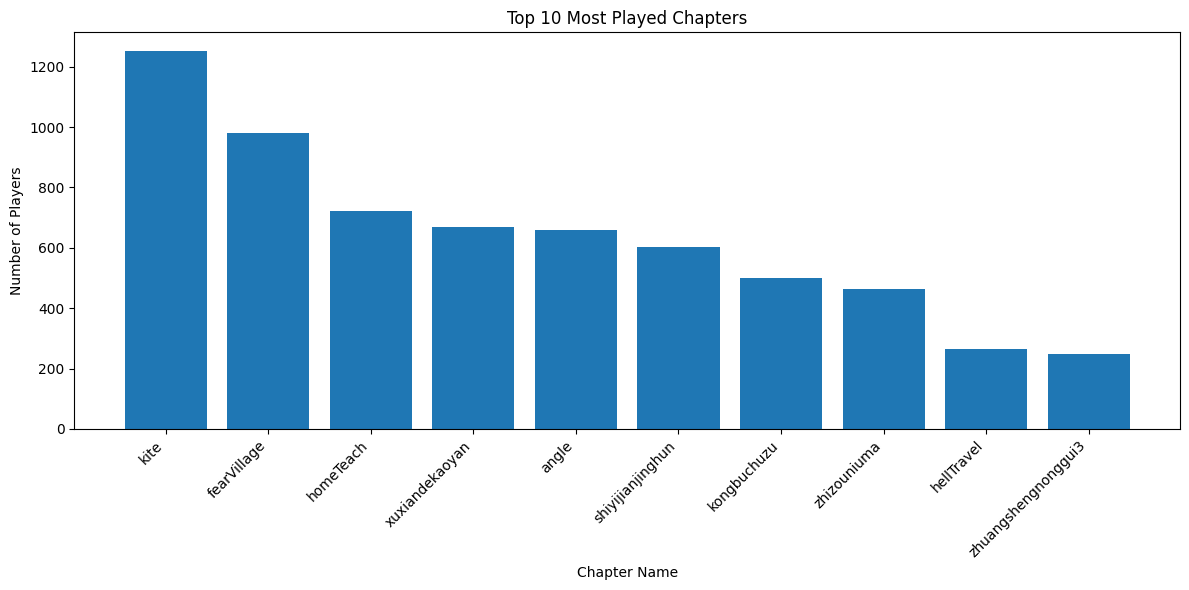


Top 10 Most Played Chapters:
Chapter 65: 1251 players
Chapter 67: 979 players
Chapter 2: 721 players
Chapter 44: 668 players
Chapter 38: 658 players
Chapter 42: 604 players
Chapter 3: 500 players
Chapter 49: 462 players
Chapter 14: 266 players
Chapter 10: 249 players


In [38]:
def analyze_top_chapters(count_array, chapter_name_dict):
    # Convert to dictionary with chapter numbers as keys
    chapter_counts = {i: count for i, count in enumerate(count_array) if count > 0}
    
    # Sort by count and get top 10
    top_10 = sorted(chapter_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # Get chapter names for display
    top_10_with_names = [
        (chapter_name_dict.get(str(num), f'Chapter {num}'), count) 
        for num, count in top_10
    ]
    
    # Plot results
    plt.figure(figsize=(12, 6))
    nums, counts = zip(*top_10)
    plt.bar(range(10), counts)
    plt.xticks(range(10), [chapter_name_dict['chapter_name'][n] for n in nums], 
               rotation=45, ha='right')
    plt.title('Top 10 Most Played Chapters')
    plt.xlabel('Chapter Name')
    plt.ylabel('Number of Players')
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nTop 10 Most Played Chapters:")
    for num, count in top_10:
        name = chapter_name_dict.get(str(num), f'Chapter {num}')
        print(f"{name}: {count} players")
    
    return top_10

# Usage
top_chapters = analyze_top_chapters(chapter_counts, get_chapter_index_dict())

将长序列处理成滑动窗口

In [53]:
def prepare_sliding_window_data(df, window_size=3, stride=1):
    # 1. 保存原始数据（不含sequence）
    base_df = df.drop(columns=['chapter_sequence'])
    
    # 2. 初始化存储列表
    windows = []          # 存储窗口序列
    labels = []          # 存储标签
    original_indices = [] # 存储原始行索引
    
    # 3. 处理每个序列
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            seq = row['chapter_sequence']
            if len(seq) >= window_size:
                # 滑动窗口处理
                for i in range(0, len(seq)-window_size+1, stride):
                    window = seq[i:i+window_size-1]  # 前n-1个数作为窗口
                    label = seq[i+window_size-1]     # 第n个数作为标签
                    windows.append(window)
                    labels.append(label)
                    original_indices.append(idx)
        except:
            continue
    
    # 4. 构建新的DataFrame
    # 复制原始行数据
    result_df = base_df.iloc[original_indices].reset_index(drop=True)
    
    # 添加新列
    result_df['window_sequence'] = windows
    result_df['next_chapter'] = labels
    
    return result_df

# 使用示例
window_size = 3  # 窗口大小
stride = 1       # 滑动步长
result_df = prepare_sliding_window_data(filter_all_df, window_size, stride)

100%|██████████| 7495/7495 [00:01<00:00, 6966.55it/s]


In [54]:
result_df.head()

,os_version,device_brand,loc_city_id,user_id,window_sequence,next_chapter
0,Android 14,xiaomi,泰州,hidfile_tt__000MXkRCTxxOeUSKTs0Ra3YGunzhp0ykItT,"[49, 42]",44
1,Android 14,xiaomi,泰州,hidfile_tt__000MXkRCTxxOeUSKTs0Ra3YGunzhp0ykItT,"[42, 44]",67
2,Android 14,xiaomi,泰州,hidfile_tt__000MXkRCTxxOeUSKTs0Ra3YGunzhp0ykItT,"[44, 67]",65
3,iOS 17.5.1,apple,天津,hidfile_tt__000my-vNrB-FLkzHXPM-CSiPFwNNyzgJYrm,"[213, 196]",42
4,iOS 17.5.1,apple,天津,hidfile_tt__000my-vNrB-FLkzHXPM-CSiPFwNNyzgJYrm,"[196, 42]",90


In [55]:
result_df.to_csv(r'D:\github_repo_forked\lifetime_value\kuaidian\clean\sliding_window_data.csv', index=False)

In [60]:
result_df.dtypes

os_version         object
device_brand       object
loc_city_id        object
user_id            object
window_sequence    object
next_chapter        int64
dtype: object

展开成单独的特征

In [ ]:
# 展开window_sequence列
window_cols = ['window_seq_{}'.format(i) for i in range(2)]  # 假设窗口大小为2
for col in window_cols:
    result_df[col] = result_df['window_sequence'].apply(lambda x: x[window_cols.index(col)])

# 删除原始的window_sequence列
result_df.drop(columns=['window_sequence'], inplace=True)

In [64]:
result_df.head()

,os_version,device_brand,loc_city_id,user_id,next_chapter,window_seq_0,window_seq_1
0,Android 14,xiaomi,泰州,hidfile_tt__000MXkRCTxxOeUSKTs0Ra3YGunzhp0ykItT,44,49,42
1,Android 14,xiaomi,泰州,hidfile_tt__000MXkRCTxxOeUSKTs0Ra3YGunzhp0ykItT,67,42,44
2,Android 14,xiaomi,泰州,hidfile_tt__000MXkRCTxxOeUSKTs0Ra3YGunzhp0ykItT,65,44,67
3,iOS 17.5.1,apple,天津,hidfile_tt__000my-vNrB-FLkzHXPM-CSiPFwNNyzgJYrm,42,213,196
4,iOS 17.5.1,apple,天津,hidfile_tt__000my-vNrB-FLkzHXPM-CSiPFwNNyzgJYrm,90,196,42


In [65]:
result_df.to_csv(r'D:\github_repo_forked\lifetime_value\kuaidian\clean\sliding_window_data_expanded.csv', index=False)